In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive"

 8thsem_ca4_photos				     dakshineswar_trip
 animals10.zip					     every_major_events_till_24
"biyebari,hardik'sbirthday,mababaniversary,pujo24"   Farewell25
'Colab Notebooks'


In [3]:
import zipfile, os

zip_path = "/content/drive/MyDrive/animals10.zip"   # <-- update this
extract_to = "/content/animals10"

os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Extracted to:", extract_to)

Extracted to: /content/animals10


In [4]:
import os, shutil, random

# Path to your extracted dataset
DATASET_DIR = "/content/animals10/raw-img"        # <--- where your folders are
OUTPUT_DIR  = "/content/animals10_split"          # <--- new cleaned dataset

# Train/val split ratio
split_ratio = 0.8

# Create output folders
train_dir = os.path.join(OUTPUT_DIR, "train")
val_dir = os.path.join(OUTPUT_DIR, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Go through each animal class folder
for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    # Make class subfolders in train and val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # List all images
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)

    # Compute split index
    split_index = int(len(images) * split_ratio)

    # Copy train images
    for img in images[:split_index]:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    # Copy val images
    for img in images[split_index:]:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

print("Dataset successfully split!")
print("Train folder:", train_dir)
print("Val folder:", val_dir)

Dataset successfully split!
Train folder: /content/animals10_split/train
Val folder: /content/animals10_split/val


In [5]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn, torch, torch.optim as optim

In [6]:
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [7]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [8]:
data_dir = "/content/animals10_split"   # keep as-is if you used the split script
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=train_tf)
val_ds   = datasets.ImageFolder(f"{data_dir}/val",   transform=val_tf)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Train samples: 20938 Val samples: 5241


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
for p in model.parameters(): p.requires_grad = False   # freeze backbone

#customize the last layer which is the linear layer
model.fc = nn.Linear(model.fc.in_features, len(train_ds.classes))
#save the model to gpu or cpu
model = model.to(device)
print(model)
print("Model head:", model.fc)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
print(criterion)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
print(optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [11]:
from tqdm import tqdm
import numpy as np

def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    running_loss=0; correct=0; total=0
    for x,y in tqdm(loader, desc="train", leave=False):
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = loss_fn(out,y)
        loss.backward()
        opt.step()
        running_loss += loss.item()*x.size(0)
        preds = out.argmax(1)
        correct += (preds==y).sum().item(); total += y.size(0)

    return running_loss/total, correct/total

def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss=0; correct=0; total=0
    all_preds=[]; all_labels=[]
    with torch.no_grad():
        for x,y in tqdm(loader, desc="eval", leave=False):
            x,y = x.to(device), y.to(device)
            out = model(x); loss = loss_fn(out,y)
            running_loss += loss.item()*x.size(0)
            preds = out.argmax(1); correct += (preds==y).sum().item(); total += y.size(0)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(y.cpu().numpy())
    return running_loss/total, correct/total, np.array(all_preds), np.array(all_labels)

In [14]:
num_epochs = 10
best_acc = 0.0
save_path = "/content/best_resnet18.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, preds, labels = evaluate(model, val_loader, criterion, device)
    print(f"Train loss: {tr_loss:.4f} acc: {tr_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model_state": model.state_dict(), "classes": train_ds.classes}, save_path)
        print("Saved best model.")
    scheduler.step()

print("Training finished. Best val acc:", best_acc)


Epoch 1/10


Train loss: 0.2205 acc: 0.9285 | Val loss: 0.1679 acc: 0.9487
Saved best model.

Epoch 2/10


Train loss: 0.2177 acc: 0.9286 | Val loss: 0.1683 acc: 0.9475

Epoch 3/10


Train loss: 0.2089 acc: 0.9315 | Val loss: 0.1556 acc: 0.9538
Saved best model.

Epoch 4/10


Train loss: 0.1913 acc: 0.9378 | Val loss: 0.1629 acc: 0.9508

Epoch 5/10


Train loss: 0.1891 acc: 0.9385 | Val loss: 0.1590 acc: 0.9519

Epoch 6/10


Train loss: 0.1867 acc: 0.9389 | Val loss: 0.1572 acc: 0.9533

Epoch 7/10


Train loss: 0.1866 acc: 0.9393 | Val loss: 0.1606 acc: 0.9521

Epoch 8/10


Train loss: 0.1887 acc: 0.9397 | Val loss: 0.1587 acc: 0.9510

Epoch 9/10


Train loss: 0.1869 acc: 0.9391 | Val loss: 0.1648 acc: 0.9494

Epoch 10/10


Train loss: 0.1839 acc: 0.9411 | Val loss: 0.1596 acc: 0.9500
Training finished. Best val acc: 0.9538256058004198


In [16]:
from sklearn.metrics import classification_report

classes = train_ds.classes
print(classification_report(labels, preds, target_names=classes))


              precision    recall  f1-score   support

        cane       0.93      0.98      0.95       973
     cavallo       0.92      0.92      0.92       525
    elefante       0.95      0.97      0.96       290
    farfalla       0.96      0.96      0.96       423
     gallina       0.99      0.96      0.97       620
       gatto       0.97      0.92      0.94       334
       mucca       0.93      0.84      0.88       374
      pecora       0.88      0.93      0.90       364
       ragno       0.98      0.98      0.98       965
  scoiattolo       0.98      0.96      0.97       373

    accuracy                           0.95      5241
   macro avg       0.95      0.94      0.94      5241
weighted avg       0.95      0.95      0.95      5241



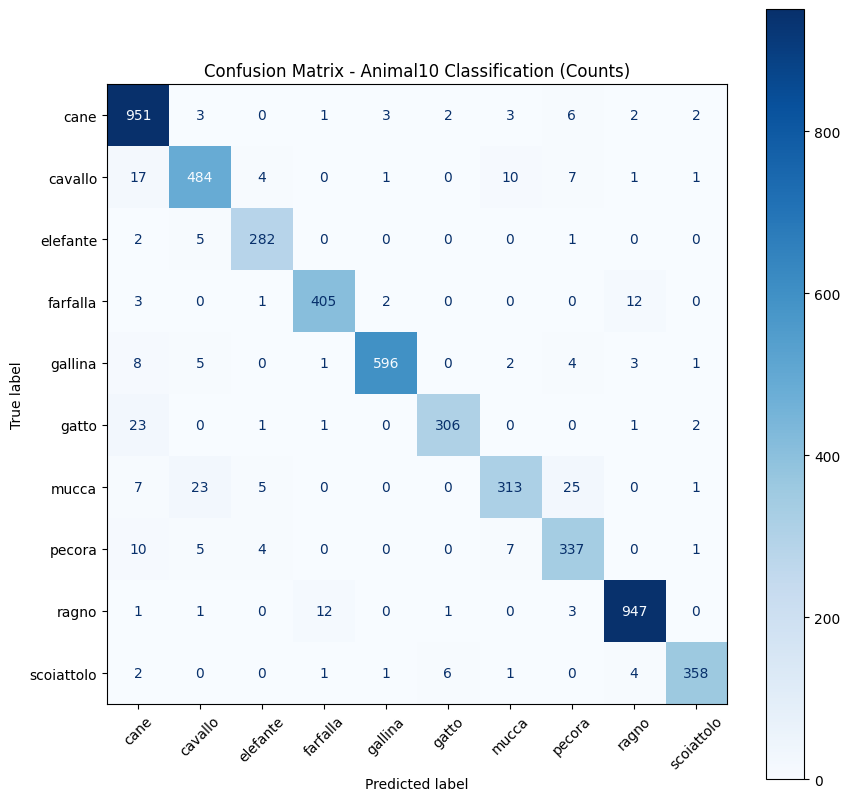

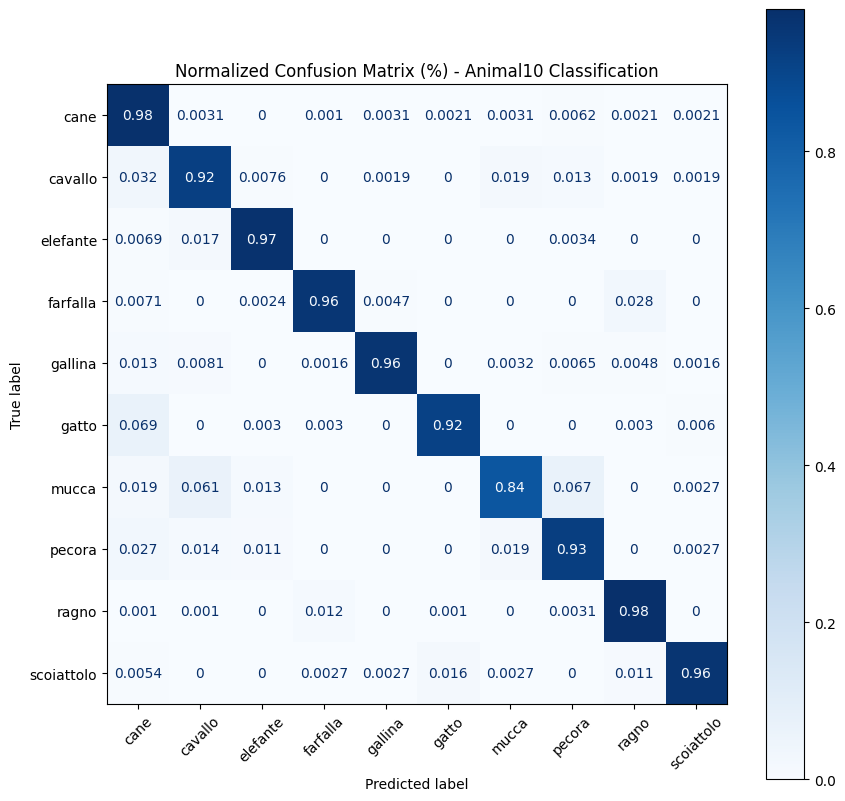

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix - Animal10 Classification (Counts)")
plt.xticks(rotation=45)
plt.show()


cm_norm = confusion_matrix(labels, preds, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", colorbar=True)
plt.title("Normalized Confusion Matrix (%) - Animal10 Classification")
plt.xticks(rotation=45)
plt.show()
